# Policy Analysis

This notebook presents code to analyse the wikipedia policy of some articles. We can measure the policy regarding different topics :

* WP content’s assignment: Assess the quality of an article. The system is based on a letter scheme that reflects principally how factually complete the article is, though language quality and layout are also factors.

* WikiProject Importance Scale: The importance rating is part of the WikiProject assessment system.It is assigned per WikiProject, not globally. It tries to answer: "How likely is it that a typical Wikipedia reader will need this article?"

* Vital Article: There are 7,085,890 articles on the English Wikipedia, and 60,000 (around 0.7%) have been selected as vital articles to the project. They are organized into five levels: Level 1 contains 10 articles. Wikiepdia most vitals one. Level 2 is 100, level 2 has 1000, level 4 has 10 000 and 5 has 50 000.
Give direction to the prioritization of improvements of English Wikipedia articles (e.g. which articles to bring to WP:GA and WP:FAstatus)
Provide a measurement of quality of overall English Wikipedia (e.g. what proportion of the most important articles are at GA and FA status)
To serve as a centralized watchlist of English Wikipedia's most important articles.

* Page protection: In some circumstances, pages may need to be protected from modification by certain groups of editors. Pages are protected when there is disruption that cannot be prevented through other means, such as blocks. Protection is a technical restriction applied only by administrators, although any user may request protection. Protection can be indefinite or expire after a specified time.

* Contentious topics: Some WP pages are assigned CT by the Arbitration Committee after users submit a CT request. Only extended-confirmed editors may make edits related to the topic area, though editors who are not extended-confirmed may post constructive comments and make edit requests related to articles within the topic area on article talk pages.

## Requierements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import requests
import time
from datetime import datetime
import csv
import mwparserfromhell
import sys
sys.path.append("/Users/garambois/Desktop/EPFL/MASTER/NX_MA1/MA_1/dhlab-cultural-weaponisation-ukraine-benchmark")

## List of control and main set of articles

In [12]:
# Articles List
control_articles = [
    "Pop music",
    "Rock and roll",
    "Eric Clapton",
    "Rolling Stone",
    "Jazz",
    "Swing",
    "Classical music",
    "Ludwig van Beethoven",
    "Wolfgang Amadeus Mozart",
    "Joseph Haydn",
    "Country music",
    "BTS",
    "K-Pop",
    "Electronic music",
    "Daft Punk",
    "Paul Kalkbrenner",
    "Trumpet",
    "Music theory",
    "Fender",
    "Marshall Amplification",
    "Jimi Hendrix",
    "Bob Marley",
    "Edith Piaf",
    "Royal Albert Hall",
    "Piano",
    "Saxophone",
    "Pink Floyd",
    "Nirvana (band)",
    "Nina Simone",
    "Music of Africa",
    "Major scale",
    "Major chord",
    "Minor chord",
    "Red Hot Chili Peppers",
    "Funk rock",
    "James Brown",
    "Dire Straits",
    "Mark Knofler",
    "John Frusciante",
    "Alan Clark",
    "Stevie Wonder",
    "Guitar"
]

control_articles = sorted(control_articles)

articles = [
    "COVID-19 pandemic in Ukraine",
    "History of Ukraine",
    "Crimea",
    "Russian annexation of Crimea",
    "2004 Ukrainian presidential election",
    "Football in Ukraine",
    "Bessarabia",
    "2014 pro-Russian unrest in Ukraine",
    "Communist Party of the Soviet Union",
    "Christianity in Russia",
    "History of Christianity in Ukraine",
    "Flag of Ukraine",
    "Alexander II of Russia",
    "Eastern Front (World War II)",
    "Bukovina",
    "Epiphanius I of Ukraine",
    "History of Crimea",
    "Dissolution of the Soviet Union",
    "Crimean Tatars",
    "Catherine the Great",
    "Culture of Ukraine",
    "Abortion in Ukraine",
    "Christmas in Ukraine",
    "Armed Forces of Ukraine",
    "Demographics of Ukraine",
    "History of Kyiv",
    "Foreign relations of Ukraine",
    "Eastern Front (World War I)",
    "Economy of Ukraine",
    "Galicia (Eastern Europe)",
    "Euromaidan",
    "History of the Russian Orthodox Church",
    "Government of Ukraine",
    "Geography of Ukraine",
    "Censuses in Ukraine",
    "Administrative divisions of Ukraine",
    "Government of the Ukrainian People's Republic in exile",
    "Education in Ukraine",
    "2022 Russian invasion of Ukraine",
    "Buddhism in Ukraine"
]

## Get the policy information for main set

The information retrieved are the current articles' status. 

In [3]:
policy_analysis_articles = pd.read_csv('../datas/interim/Policy Analysis/policy_analysis_articles.csv')
policy_analysis_control_articles = pd.read_csv('../datas/interim/Policy Analysis/policy_analysis_control_articles.csv')

### Functions and details to get the policy information for main set 

In [9]:
URL = "https://en.wikipedia.org/w/api.php"

HEADERS = {
    "User-Agent": "DH_Project/1.0 (maxime.garambois@epfl.ch)"
}

CONTENTIOUS_KEYWORDS = ["contentious topics/"]

def get_talk_wikitext(title):
    """Retrieve raw wikitext of the Talk page."""
    params = {
        "action": "query",
        "titles": f"Talk:{title}",
        "prop": "revisions",
        "rvslots": "main",
        "rvprop": "content",
        "formatversion": "2",
        "format": "json"
    }
    response = requests.get(url=URL, params=params, headers=HEADERS)
    data = response.json()

    page = data["query"]["pages"][0]
    if "missing" in page:
        return None  # talk page doesn't exist

    return page["revisions"][0]["slots"]["main"]["content"]


def parse_assessments(wikitext):
    """Parse class, importance values, and contentious-topic status from wikitext."""
    code = mwparserfromhell.parse(wikitext)

    results = {
        "class": None,
        "importance": {},
        "contentious": False
    }

    for template in code.filter_templates():
        name = template.name.strip().lower()

        # GLOBAL CLASS (from banner shell)
        if "banner shell" in name:
            if template.has("class"):
                results["class"] = str(template.get("class").value).strip()

        # PER-WIKIPROJECT IMPORTANCE
        if "wikiproject" in name and not "banner shell" in name:
            project = template.name.strip().replace("WikiProject", "").strip()

            # look for either "importance" or "priority"
            if template.has("importance"):
                imp = str(template.get("importance").value).strip()
                results["importance"][project] = imp
            elif template.has("priority"):
                # Some projects use "priority" (e.g., Mathematics)
                imp = str(template.get("priority").value).strip()
                results["importance"][project] = imp

        # CONTENTIOUS TOPICS DETECTION
        temp_text = str(template).lower()
        if any(keyword in name for keyword in CONTENTIOUS_KEYWORDS):
            results["contentious"] = True

    return results


def get_article_assessment(title):
    """Main wrapper: fetch talk page and parse assessment."""
    wikitext = get_talk_wikitext(title)
    if not wikitext:
        return {"error": "Talk page does not exist"}

    return parse_assessments(wikitext)

def extract_relevant_importance(importance_dict):
    """
    From all WikiProject importance values:
    - If 'Ukraine' exists -> return that value.
    - Else -> return the first value in the dict.
    - If dict empty -> return None.
    """
    if not importance_dict:
        return None

    # Prefer Ukraine rating if present
    if "Ukraine" in importance_dict:
        return importance_dict["Ukraine"]

    # Otherwise take the first key in the dict
    first_key = next(iter(importance_dict))
    return importance_dict[first_key]

def get_data(articles_list, out_csv):
    rows = []

    for article in articles_list:
        assessment = get_article_assessment(article)

        # Extract global class
        article_class = assessment.get("class")

        # Extract importance from rules
        importance = extract_relevant_importance(assessment.get("importance", {}))

        # Contentious topic boolean
        contentious = assessment.get("contentious")

        rows.append({
            "article": article,
            "class": article_class,
            "importance": importance,
            "contentious": contentious
        })

    # Save CSV
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["article", "class", "importance", "contentious"])
        writer.writeheader()
        writer.writerows(rows)

    print(f"✅ CSV saved at: {out_csv}")

OUT_CSV = '../datas/interim/Policy Analysis/policy_analysis_control_articles.csv'
get_data(control_articles, OUT_CSV)

✅ CSV saved at: ../datas/interim/Policy Analysis/policy_analysis_control_articles.csv


In [6]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import unquote
import re

API = "https://en.wikipedia.org/w/api.php"
HEADERS = {"User-Agent": "DH_Project/1.0 (maxime.garambois@epfl.ch)"}

def mw_normalize_and_redirects(title):
    """Return canonical title + any redirects (all with underscores)."""
    params = {
        "action": "query",
        "titles": title,
        "redirects": "1",
        "format": "json",
        "formatversion": "2",
    }
    r = requests.get(API, params=params, headers=HEADERS).json()
    pages = r.get("query", {}).get("pages", [])
    if not pages or "missing" in pages[0]:
        # fall back to the provided title
        return {title.replace(" ", "_")}
    canonical = pages[0]["title"].replace(" ", "_")
    candidates = {canonical}
    for redir in r["query"].get("redirects", []):
        candidates.add(redir["from"].replace(" ", "_"))
        candidates.add(redir["to"].replace(" ", "_"))
    return candidates

def parse_page_html(title):
    """Fetch parsed HTML for a wiki page title."""
    params = {"action": "parse", "page": title, "prop": "text", "format": "json"}
    r = requests.get(API, params=params, headers=HEADERS).json()
    if "error" in r:
        return None
    return r["parse"]["text"]["*"]

def collect_level_subpages(level):
    """
    From the root VA page for a level, collect all subpages like:
    Wikipedia:Vital articles/Level/<level>/People, /History, etc.
    Include the root too (some levels have direct links).
    """
    root = f"Wikipedia:Vital articles/Level/{level}"
    html = parse_page_html(root)
    subpages = set()
    if html:
        soup = BeautifulSoup(html, "html.parser")
        for a in soup.find_all("a"):
            href = a.get("href", "")
            title = a.get("title", "")
            # Prefer title (cleaner), but fall back to href if needed
            if title.startswith(f"Wikipedia:Vital articles/Level/{level}/"):
                subpages.add(title)
            elif href.startswith("/wiki/Wikipedia:Vital_articles/Level/"):
                # Extract after /wiki/
                target = href[len("/wiki/"):]
                if re.match(rf"Wikipedia:Vital_articles/Level/{level}\b", target):
                    subpages.add(target)
    subpages.add(root)
    return subpages

def vital_level_via_lists(article_title):
    """
    Search Vital Articles lists (levels 1..5) and return the level number
    where the article appears, or None if not found.
    """
    acceptable = {t.lower() for t in mw_normalize_and_redirects(article_title)}

    for level in range(1, 6):
        for subpage in collect_level_subpages(level):
            html = parse_page_html(subpage)
            if not html:
                continue
            soup = BeautifulSoup(html, "html.parser")
            for a in soup.find_all("a"):
                # Use the title attribute: it's the canonical page title
                if a.has_attr("title"):
                    link_title = a["title"].replace(" ", "_").lower()
                    if link_title in acceptable:
                        return level
                else:
                    # Fallback to href if no title (rare)
                    href = a.get("href", "")
                    if href.startswith("/wiki/"):
                        target = href[len("/wiki/"):].split("#", 1)[0]
                        target = unquote(target).replace(" ", "_").lower()
                        if target in acceptable:
                            return level
    return None

for article in articles:
    level = vital_level_via_lists(article)
    print(article, level)

## Try to get the evolution of the policy through time for each article

### Grade - Importance - Vital level

In [30]:
# Try to store the article's metadata changes in a timeline
WIKI_API = "https://en.wikipedia.org/w/api.php"
USER_AGENT = "DH_Project/1.0 (maxime.garambois@epfl.ch)"
SLEEP = 0.5

def request_api(params):
    """Send a request to the API with retry and user-agent."""
    headers = {"User-Agent": USER_AGENT}
    while True:
        try:
            response = requests.get(WIKI_API, params=params, headers=headers, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Retrying due to error: {e}")
            time.sleep(2)

def fetch_talk_revisions(article_title):
    """
    Fetch all wikitext revisions of the Talk:Article page.
    Returns a list of dicts: {rev_id, timestamp, content}
    """
    talk_title = f"Talk:{article_title}"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": talk_title,
        "rvprop": "ids|timestamp|content",
        "rvslots": "main",
        "rvlimit": "500",
    }

    revisions = []
    cont = True

    while cont:
        data = request_api(params)

        pages = data["query"]["pages"]
        page = next(iter(pages.values()))

        if "revisions" in page:
            for rev in page["revisions"]:
                revisions.append({
                    "rev_id": rev["revid"],
                    "timestamp": rev["timestamp"],
                    "content": rev["slots"]["main"].get("*", ""),
                })

        if "continue" in data:
            params.update(data["continue"])
        else:
            cont = False

        time.sleep(SLEEP)

    # sort from oldest → newest
    revisions.sort(key=lambda r: r["timestamp"])
    return revisions

# Regex patterns for WikiProject templates, quality, and importance
WIKIPROJECT_RE = re.compile(r"\{\{[Ww]ikiProject [^|}]+(?:\|[^}]+)?\}\}")
CLASS_RE = re.compile(r"class\s*=\s*([A-Za-z]+)", re.IGNORECASE)
IMPORTANCE_RE = re.compile(r"importance\s*=\s*([A-Za-z]+)", re.IGNORECASE)

VITAL_RE = re.compile(r"\{\{[Vv]ital article(?:\|level\s*=\s*(\d+))?", re.IGNORECASE)


def extract_metadata(wikitext):
    """Extract class, importance, vital-level metadata from a talk page revision."""
    
    class_rating = None
    importance_rating = None
    vital_level = None

    # 1. Parse WikiProject templates
    for template in WIKIPROJECT_RE.findall(wikitext):
        class_match = CLASS_RE.search(template)
        if class_match:
            class_rating = class_match.group(1).upper()

        imp_match = IMPORTANCE_RE.search(template)
        if imp_match:
            importance_rating = imp_match.group(1).capitalize()

    # 2. Parse Vital Article level
    vital_match = VITAL_RE.search(wikitext)
    if vital_match:
        vital_level = vital_match.group(1) or "yes"

    return {
        "class": class_rating,
        "importance": importance_rating,
        "vital": vital_level,
    }

def build_metadata_timeline(talk_revisions):
    """
    Returns a list of metadata changes:
    [
        {
            "timestamp": "...",
            "rev_id": ...,
            "class": "C",
            "importance": "High",
            "vital": "4"
        },
        ...
    ]
    Only stores metadata when it changes.
    """
    timeline = []
    last_state = {"class": None, "importance": None, "vital": None}

    for rev in talk_revisions:
        meta = extract_metadata(rev["content"])

        if meta != last_state:
            timeline.append({
                "timestamp": rev["timestamp"],
                "rev_id": rev["rev_id"],
                **meta
            })
            last_state = meta.copy()

    return timeline

def extract_article_metadata_timeline(article_title):
    print(f"\n=== Fetching Talk Page revisions for: {article_title} ===")
    talk_revs = fetch_talk_revisions(article_title)
    print(f"Fetched {len(talk_revs)} talk revisions.")

    print("=== Parsing metadata changes (Option B) ===")
    timeline = build_metadata_timeline(talk_revs)

    print(f"Metadata change points: {len(timeline)}")
    return timeline

In [ ]:
import requests
import pandas as pd
import time

rows = []  # will hold one flattened JSON row per article

for t in control_articles:
    url = f"https://xtools.wmcloud.org/api/page/pageinfo/en.wikipedia.org/{t}"
    params = {"format": "json"}
    headers = {"accept": "application/json"}

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        data = response.json()
        row = pd.json_normalize(data)

        # add the article title (helps debugging later)
        row["article"] = t

        rows.append(row)

    else:
        print(f"Error for {t}: {response.status_code}")

    time.sleep(0.5)  # avoid rate limit

In [3]:
import re
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import requests
import time

URL = "https://en.wikipedia.org/w/api.php"
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

# -------------------------
# API FOR PROTECTION STATUS
# -------------------------

def get_article_creation_date(title):
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": title,
        "rvlimit": 1,
        "rvprop": "timestamp|user|comment",
        "rvdir": "newer"    # first revision = creation
    }

    r = requests.get(URL, params=params, headers=HEADERS)
    data = r.json()

    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return None

    rev = page["revisions"][0]
    return {
        "timestamp": rev["timestamp"],
        "user": rev.get("user"),
        "comment": rev.get("comment")
    }


def get_article_protection_status(article_title):
    """
    Get the protection staturs of an article
    The status can be :
    - fully protected 
    - semi-protected
    - template protected
    - ...
    """
    
    session = requests.Session()
    session.headers.update(HEADERS)

    params = {
        "action": "query",
        "titles": article_title,
        "prop": "info",
        "inprop": "protection",
        "format": "json"
    }

    response = requests.get(url=URL, params=params, headers=HEADERS)
    data = response.json()

    # Extract page object (the pageid is unknown => key is not fixed)
    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return {"status": "missing", "protections": []}

    protections = page.get("protection", [])

    # If no protection entries → page is fully open
    if not protections:
        return {"status": "unprotected", "protections": []} 

    # Convert the protection status to understand better
    status = "custom protection"
    for prot in protections:
        action = prot.get("type")
        level = prot.get("level")

        if action == "edit":
            if level == "autoconfirmed":
                status = "semi-protected"
            elif level == "extendedconfirmed":
                status = "extended-protected"
            elif level == "sysop":
                status = "fully protected"
        elif action == "move" and level == "sysop":
            status = "move-protected"

    return {
        "status": status,
        "protections": protections  # raw list for further analysis
    }

def get_article_protection_history(article_title):
    """
    Retrieve the full protection history of an article using MediaWiki logevents.
    Returns a sorted list of protection events including timestamp, action,
    protection levels, expiry, and comments.
    """

    session = requests.Session()
    session.headers.update(HEADERS)

    events = []
    cont = {}

    while True:
        params = {
            "action": "query",
            "list": "logevents",
            "letype": "protect",
            "letitle": article_title,
            "lelimit": "max",
            "format": "json",
            **cont
        }

        response = session.get(URL, params=params)
        data = response.json()

        for ev in data["query"]["logevents"]:
            event = {
                "timestamp": ev.get("timestamp"),
                "user": ev.get("user"),
                "action": ev.get("action"),        # protect / modify / unprotect / move_prot
                "comment": ev.get("comment"),

                # details with levels and expiry (may be missing)
                "protection": ev.get("params", {}).get("details", []),
            }
            events.append(event)

        # Continue if there's more data
        if "continue" in data:
            cont = data["continue"]
        else:
            break

    # Sort chronologically
    events.sort(key=lambda x: x["timestamp"])

    return events

# -----------------------------
# METHODS FOR PROTECTION STATUS 
# -----------------------------

def parse_old_protection(comment):
    """
    Extracts old-style MediaWiki protection settings from a log comment.
    Example: "edit war [edit=sysop:move=sysop]"
    Returns dict: {"edit": "sysop", "move": "sysop"}
    """
    match = re.search(r"\[(.*?)\]", comment)
    if not match:
        return {}

    content = match.group(1)
    rules = content.split(":")

    prot = {}
    for rule in rules:
        if "=" in rule:
            key, value = rule.split("=", 1)
            prot[key.strip()] = value.strip()

    return prot


def resolve_status(prot_dict):
    """
    Convert a dict of edit/move protection settings to a unified status string.
    Used for new-style AND old-style protections.
    """
    edit = prot_dict.get("edit")
    move = prot_dict.get("move")

    if edit == "sysop":
        return "fully protected"
    if edit == "extendedconfirmed":
        return "extended-protected"
    if edit == "autoconfirmed":
        return "semi-protected"
    if move == "sysop":
        return "move-protected"

    return "unprotected"


def build_protection_timeline(article_title):
    """
    Build chronological protection timeline with:
      - new-style MW protection data (post-2010)
      - old-style comment-embedded protection info (pre-2010)

    Output:
        [
          {"start": datetime, "end": datetime, "status": "unprotected"},
          {"start": datetime, "end": datetime, "status": "semi-protected"},
          ...
        ]
    """

    events = get_article_protection_history(article_title)

    # If no protection events at all → always unprotected
    if not events:
        # Try to use creation date if available; otherwise return None/None
        creation_info = get_article_creation_date(article_title)
        if creation_info and "timestamp" in creation_info:
            creation_dt = datetime.fromisoformat(
                creation_info["timestamp"].replace("Z", "+00:00")
            )
            return [{
                "start": creation_dt,
                "end": datetime.utcnow(),
                "status": "unprotected"
            }]
        else:
            return [{
                "start": None,
                "end": None,
                "status": "unprotected"
            }]

    # --- Initial state: article just born, unprotected ---
    creation_info = get_article_creation_date(article_title)
    creation_dt = datetime.fromisoformat(
        creation_info["timestamp"].replace("Z", "+00:00")
    )

    timeline = []
    current_status = "unprotected"
    current_start = creation_dt

    # events should already be chronological, but just to be safe:
    events = sorted(events, key=lambda e: e["timestamp"])

    for ev in events:
        timestamp = datetime.fromisoformat(ev["timestamp"].replace("Z", "+00:00"))
        action = ev.get("action")
        protections = ev.get("protection", [])
        comment = ev.get("comment", "")

        # Start by assuming status stays the same
        new_status = current_status

        # --- CASE 1: explicit unprotect ---
        if action == "unprotect":
            new_status = "unprotected"

        # --- CASE 2: protect / modify / move_prot → set some level ---
        elif action in ("protect", "modify", "move_prot", "move_protect"):
            prot_dict = {}

            # (1) Try new-style protection entries from API
            for prot in protections:
                ptype = prot.get("type")   # "edit", "move", ...
                level = prot.get("level")  # "sysop", "autoconfirmed", ...
                if ptype and level:
                    prot_dict[ptype] = level

            # (2) If nothing found → try old-style [edit=sysop:move=sysop]
            if not prot_dict:
                old = parse_old_protection(comment)
                prot_dict.update(old)

            # (3) Resolve final status from prot_dict
            new_status = resolve_status(prot_dict)

        # else: action not recognised (rare) → keep current_status

        # --- If status changed, close previous interval and start a new one ---
        if new_status != current_status:
            # close previous interval
            timeline.append({
                "start": current_start,
                "end": timestamp,
                "status": current_status
            })

            # start new interval
            current_start = timestamp
            current_status = new_status

    # Close the last interval, ending at "now"
    timeline.append({
        "start": current_start,
        "end": datetime.utcnow(),
        "status": current_status
    })

    return timeline


PROTECTION_COLORS = {
    "unprotected": "#C0C0C0",
    "semi-protected": "#1f77b4",
    "extended-protected": "#ff7f0e",
    "fully protected": "#d62728",
    "move-protected": "#9467bd",
}

from matplotlib.patches import Patch

def plot_protection_timelines(timelines):
    """
    Gantt-style plot for multiple articles.
    timelines: dict => {article_name: [intervals]}
    """

    articles = sorted(timelines.keys())  # alphabetical
    fig, ax = plt.subplots(figsize=(14, len(articles) * 0.4))

    y_pos = 0
    height = 0.8

    for article in articles:
        intervals = timelines[article]

        for interval in intervals:
            start = interval["start"]
            end = interval["end"]
            status = interval["status"]

            if start is None or end is None:
                continue

            ax.broken_barh(
                [(mdates.date2num(start), mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=PROTECTION_COLORS.get(status, "black"),
                edgecolor="none"
            )

        ax.text(
            mdates.date2num(intervals[0]["start"]) - 50, 
            y_pos + height / 2,
            article, va="center", ha="right"
        )

        y_pos += 1

    # --- remove black frame / spines ---
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- add legend ---
    legend_handles = [
        Patch(facecolor=color, label=status)
        for status, color in PROTECTION_COLORS.items()
    ]
    ax.legend(
        handles=legend_handles,
        title="Protection Status",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Protection Evolution Timeline (40 Articles)", fontsize=14)
    plt.tight_layout()
    plt.show()

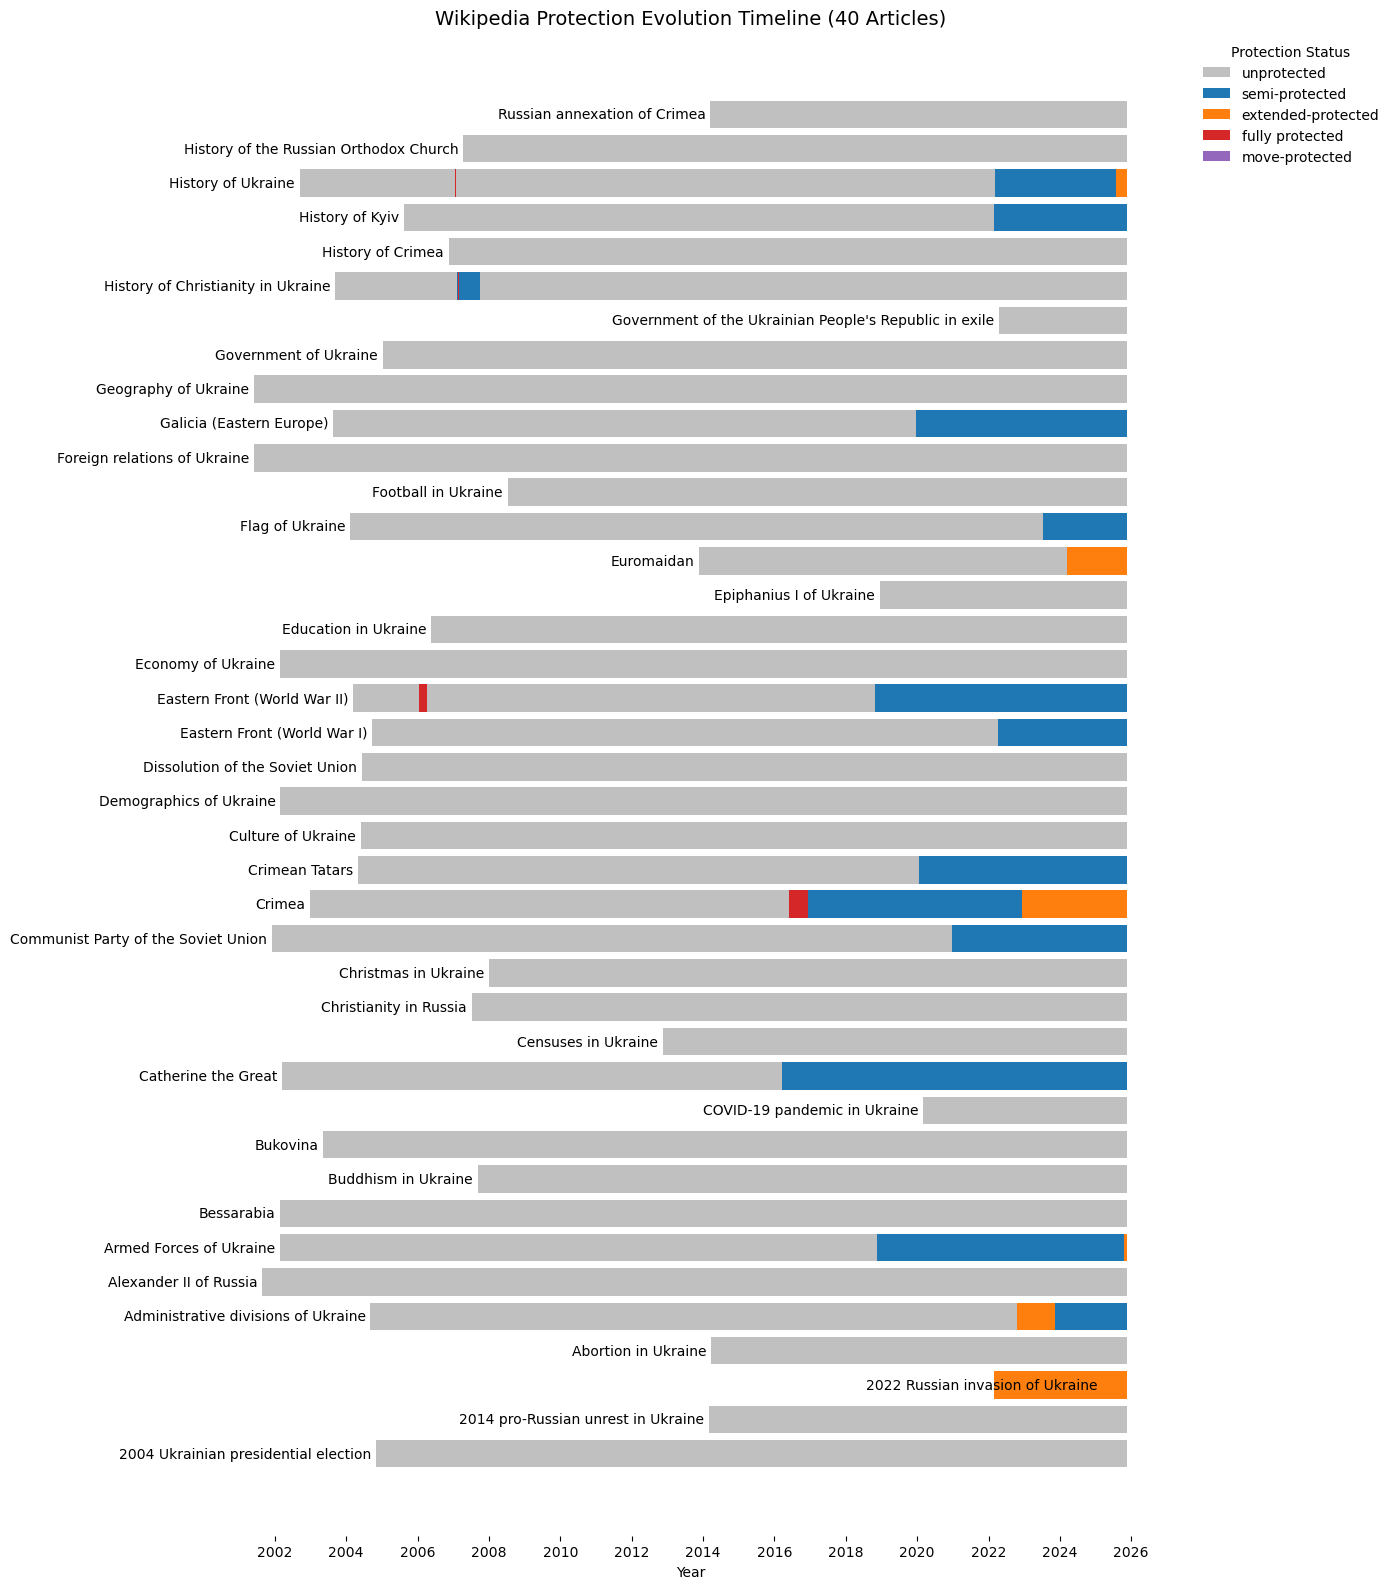

In [28]:
timelines = {}

for title in articles:
    timelines[title] = build_protection_timeline(title)

plot_protection_timelines(timelines)

In [27]:
timelines = {}
for title in articles[:10]:
    timelines[title] = build_protection_timeline(title)

from datetime import timezone

def timelines_to_dataframe(timelines):
    """
    Convert the timelines dict into a pandas DataFrame with:
    article | start | end | status | diff (days)
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []

    for article, intervals in timelines.items():
        for interval in intervals:
            start = interval["start"]
            end = interval["end"]
            status = interval["status"]

            # Normalize timezone to UTC
            if start is not None:
                if start.tzinfo is None:
                    start = start.replace(tzinfo=timezone.utc)
                else:
                    start = start.astimezone(timezone.utc)

            if end is not None:
                if end.tzinfo is None:
                    end = end.replace(tzinfo=timezone.utc)
                else:
                    end = end.astimezone(timezone.utc)

            # Compute difference in days
            diff_days = (end - start).days if start and end else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "status": status,
                "diff": diff_days
            })

    return pd.DataFrame(rows)

pd_protect = timelines_to_dataframe(timelines)
pd_protect

,article,start,end,status,diff
0,COVID-19 pandemic in Ukraine,2020-03-03 23:46:58+00:00,2025-11-21 08:59:14.227749+00:00,unprotected,2088
1,History of Ukraine,2002-09-13 10:55:09+00:00,2007-01-17 10:45:28+00:00,unprotected,1586
2,History of Ukraine,2007-01-17 10:45:28+00:00,2007-01-26 04:24:28+00:00,fully protected,8
3,History of Ukraine,2007-01-26 04:24:28+00:00,2022-03-04 07:47:14+00:00,unprotected,5516
4,History of Ukraine,2022-03-04 07:47:14+00:00,2025-07-24 15:14:20+00:00,semi-protected,1238
5,History of Ukraine,2025-07-24 15:14:20+00:00,2025-11-21 08:59:14.705976+00:00,extended-protected,119
6,Crimea,2002-12-30 18:55:43+00:00,2016-06-03 01:16:24+00:00,unprotected,4903
7,Crimea,2016-06-03 01:16:24+00:00,2016-12-05 16:52:13+00:00,fully protected,185
8,Crimea,2016-12-05 16:52:13+00:00,2022-12-07 20:19:06+00:00,semi-protected,2193
9,Crimea,2022-12-07 20:19:06+00:00,2025-11-21 08:59:15.198146+00:00,extended-protected,1079
